In [1]:
import os

os.environ.get('GDS_ENV_VERSION')

'6.0alpha'

# Generate illustrations of tessellation

In [2]:
import geopandas as gpd
import momepy as mm
import pygeos
import numpy as np
from scipy.spatial import Voronoi
import pandas as pd
from mapclassify import greedy
import contextily as ctx
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dq2ou8_z because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
gdf = gpd.read_file(mm.datasets.get_path('bubenec'), layer='buildings')

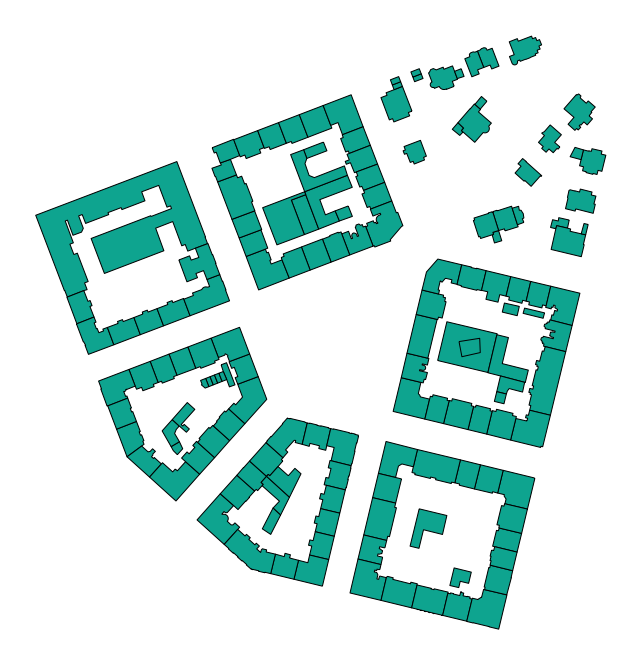

In [190]:
gdf.plot(figsize=(12, 12), color='#0ea48f', edgecolor='k').set_axis_off()

In [4]:
limit = mm.buffered_limit(gdf, 50)

## Step 1: Shrink

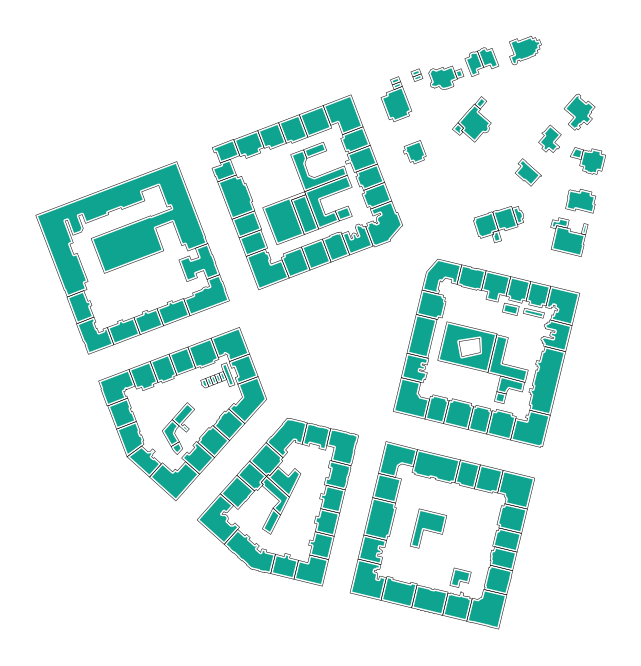

In [178]:
shrinked = gdf.buffer(-2)
ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
shrinked.plot(ax=ax, color='#0ea48f')
ax.set_axis_off()

## Step 2: Point array

In [181]:
distance = 4

points = np.empty((0, 2))
ids = []
lines = shrinked.exterior.values.data
lines[26] = pygeos.from_shapely(shrinked.geometry.values[26].boundary)  # pygeos bugfix
lengths = shrinked.length
for ix, line, length in zip(shrinked.index, lines, lengths):
    pts = pygeos.line_interpolate_point(
        line,
        np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
    )  # .1 offset to keep a gap between two segments
    if len(pts) > 0:
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)

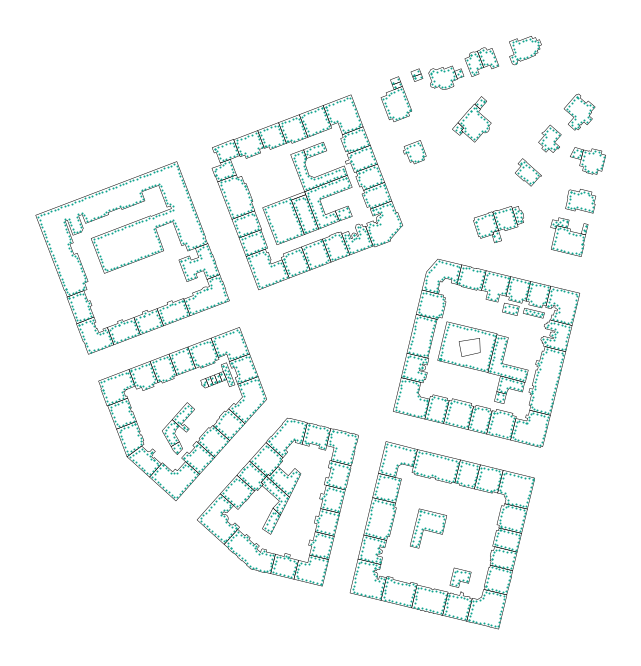

In [182]:
ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
gpd.GeoSeries(pygeos.points(points)).plot(ax=ax, markersize=1, color='#0ea48f')
ax.set_axis_off()

In [183]:
# add hull to resolve issues with infinity
# this is just a correction step ensuring the algorithm will work correctly
series = gpd.GeoSeries(limit)
bounds = series.total_bounds
width = bounds[2] - bounds[0]
leng = bounds[3] - bounds[1]
hull = series.geometry[[0]].buffer(2 * width if width > leng else 2 * leng)
line = hull.boundary.values.data[0]
length = hull.length[0]

In [184]:
pts = pygeos.line_interpolate_point(
    line,
    np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
)  # .1 offset to keep a gap between two segments
points = np.append(points, pygeos.get_coordinates(pts), axis=0)
ids += [-1] * len(pts)

## Step 3: Voronoi

In [185]:
voronoi_diagram = Voronoi(np.array(points))

vertices = pd.Series(voronoi_diagram.regions).take(voronoi_diagram.point_region)
polygons = []
for region in vertices:
    if -1 not in region:
        polygons.append(pygeos.polygons(voronoi_diagram.vertices[region]))
    else:
        polygons.append(None)

regions_gdf = gpd.GeoDataFrame(
    {'unique_id': ids}, geometry=polygons
).dropna()
regions_gdf = regions_gdf.loc[
    regions_gdf['unique_id'] != -1
]  # delete hull-based cells

In [186]:
voronoi_tessellation = gpd.clip(regions_gdf, series)

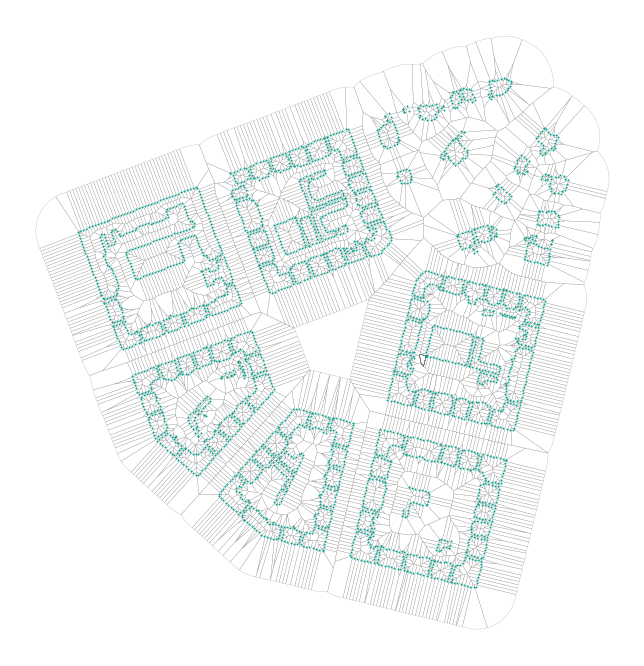

In [187]:
# ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k', zorder=2)
ax = gpd.GeoSeries(pygeos.points(points[:3333])).plot(figsize=(12, 12), markersize=1, zorder=3, color='#0ea48f')
voronoi_tessellation.plot(ax=ax, facecolor='none', linewidth=.2, edgecolor='gray')
ax.set_axis_off()

## Step 4: Dissolve

In [188]:
tessellation = voronoi_tessellation.dissolve('unique_id')

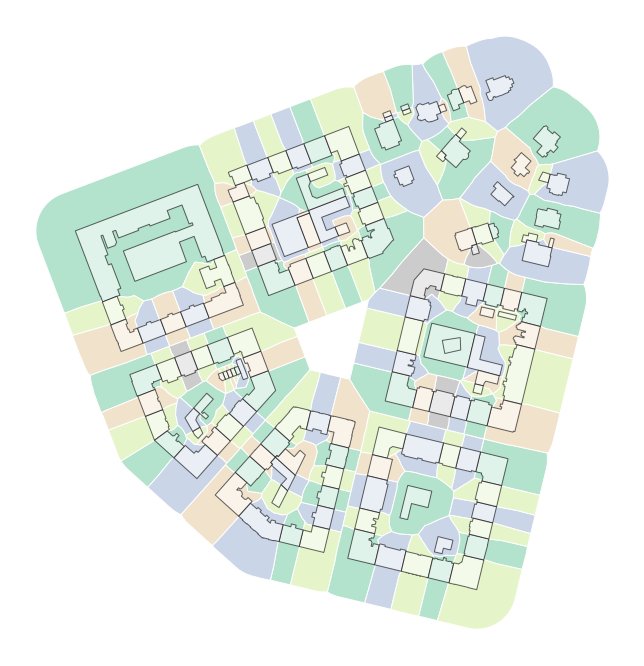

In [189]:
ax = gdf.plot(figsize=(12, 12), facecolor='white', zorder=2, alpha=.6, edgecolor='k')
tessellation.plot(greedy(tessellation, strategy='largest_first'), ax=ax, categorical=True, cmap='Pastel2', edgecolor='w')
ax.set_axis_off()

## OSM data
### Barcelona

In [67]:
import osmnx as ox

point = (41.3907594, 2.1573404)
dist = 250
gdf = ox.footprints.footprints_from_point(point, dist)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/osmnx/footprints.py:44: UserWarning: The `footprints` module has been deprecated and will be removed in a future release. Instead, use the `geometries` module's `geometries_from_point` function, passing `tags={'building':True}`.
  warnings.warn(msg)


In [68]:
gdf_projected = ox.projection.project_gdf(gdf)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
from shapely.geometry import Point

bounds = gdf_projected.total_bounds
limit = Point(np.mean([bounds[0], bounds[2]]), np.mean([bounds[1], bounds[3]])).buffer(250)
barcelona = gpd.clip(gdf_projected, limit)
bcn_bounds = barcelona.total_bounds

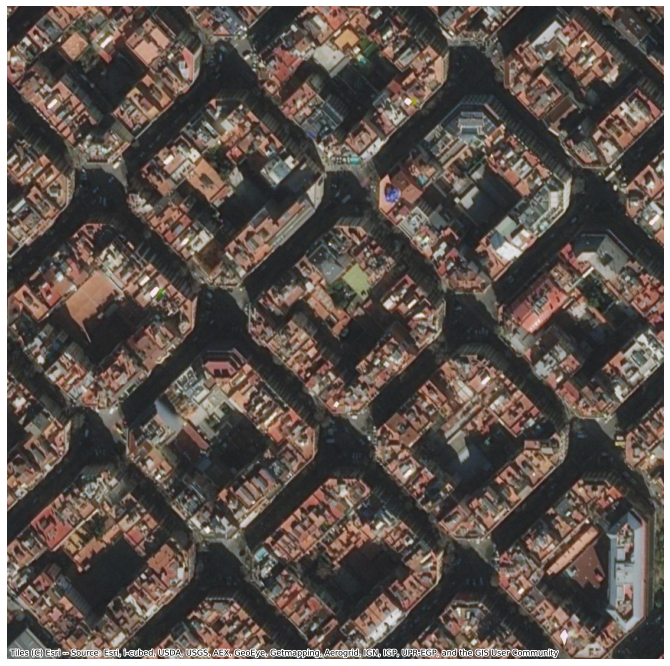

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis([bcn_bounds[0], bcn_bounds[2], bcn_bounds[1], bcn_bounds[3]])
ctx.add_basemap(ax, crs=gdf_projected.crs, source=ctx.providers.Esri.WorldImagery)
ax.set_axis_off()

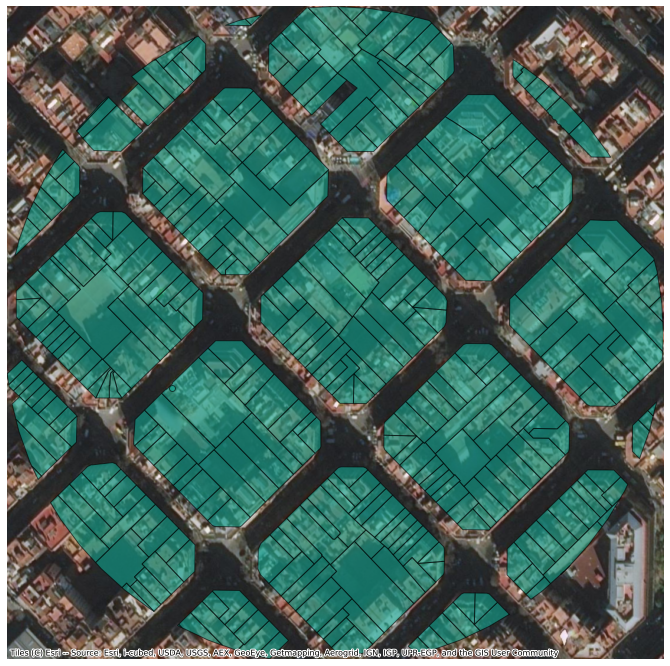

In [71]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis([bcn_bounds[0], bcn_bounds[2], bcn_bounds[1], bcn_bounds[3]])
ctx.add_basemap(ax, crs=gdf_projected.crs, source=ctx.providers.Esri.WorldImagery)
barcelona.plot(ax=ax, color='#0ea48f', edgecolor='k', alpha=.6)
ax.set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


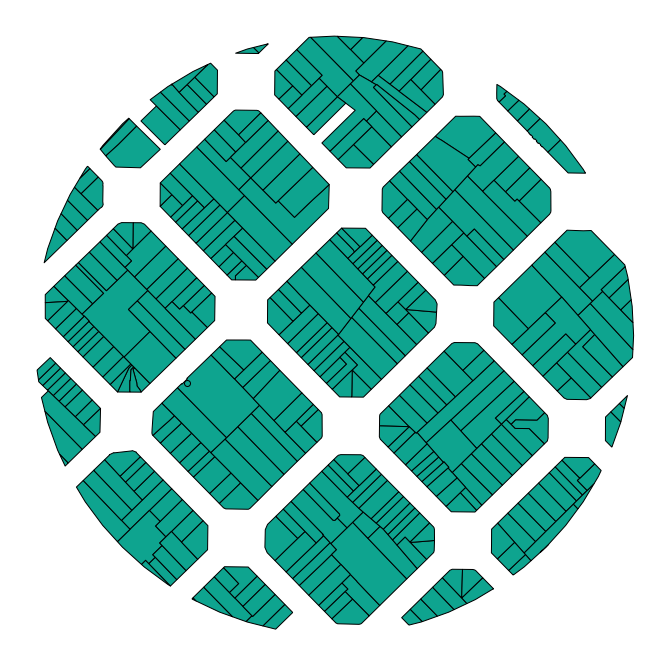

In [72]:
barcelona.plot(figsize=(12, 12), color='#0ea48f', edgecolor='k').set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


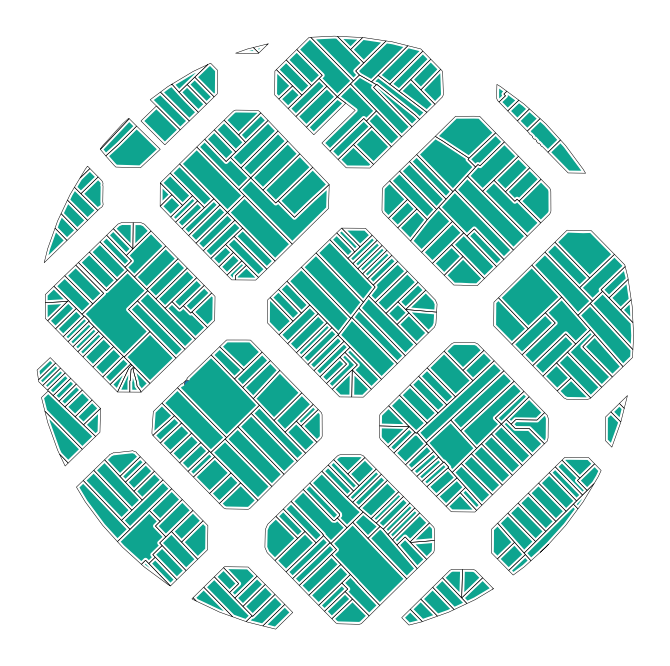

In [73]:
shrinked = barcelona.buffer(-2)
shrinked = shrinked[~shrinked.is_empty]
ax = barcelona.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
shrinked.plot(ax=ax, color='#0ea48f')
ax.set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


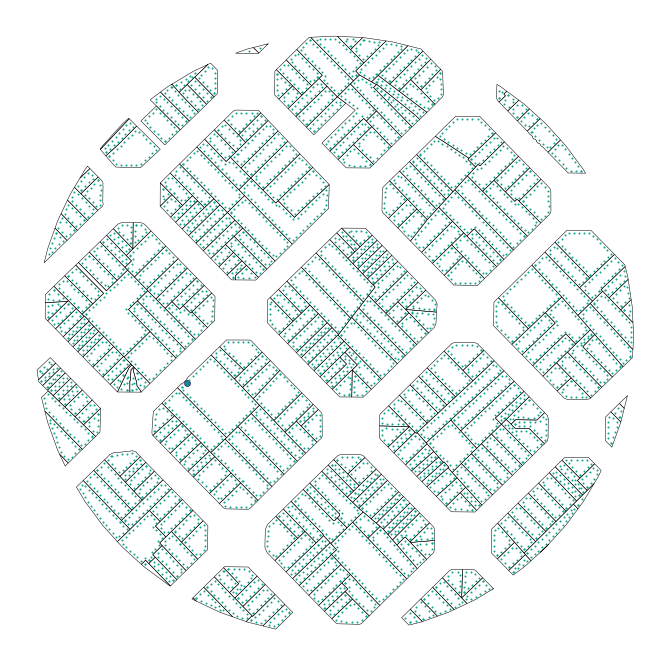

In [74]:
distance = 4

points = np.empty((0, 2))
ids = []
lines = shrinked.exterior.values.data
lines[26] = pygeos.from_shapely(shrinked.geometry.values[26].boundary)  # pygeos bugfix
lengths = shrinked.length
for ix, line, length in zip(shrinked.index, lines, lengths):
    pts = pygeos.line_interpolate_point(
        line,
        np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
    )  # .1 offset to keep a gap between two segments
    if len(pts) > 0:
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)

ax = barcelona.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
gpd.GeoSeries(pygeos.points(points)).plot(ax=ax, markersize=1, color='#0ea48f')
ax.set_axis_off()

In [75]:
# add hull to resolve issues with infinity
# this is just a correction step ensuring the algorithm will work correctly
print(points.shape)
series = gpd.GeoSeries(limit)
hull = series.geometry[[0]].buffer(500)
line = hull.boundary.values.data[0]
length = hull.length[0]
pts = pygeos.line_interpolate_point(
    line,
    np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
)  # .1 offset to keep a gap between two segments
points = np.append(points, pygeos.get_coordinates(pts), axis=0)
ids += [-1] * len(pts)

(5831, 2)
/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


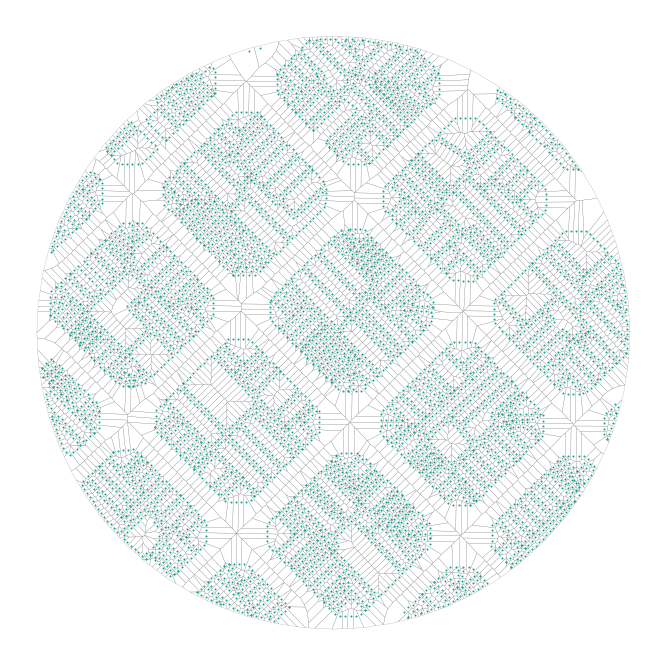

In [76]:
voronoi_diagram = Voronoi(np.array(points))

vertices = pd.Series(voronoi_diagram.regions).take(voronoi_diagram.point_region)
polygons = []
for region in vertices:
    if -1 not in region:
        polygons.append(pygeos.polygons(voronoi_diagram.vertices[region]))
    else:
        polygons.append(None)

regions_gdf = gpd.GeoDataFrame(
    {'unique_id': ids}, geometry=polygons
).dropna()
regions_gdf = regions_gdf.loc[
    regions_gdf['unique_id'] != -1
]  # delete hull-based cells
voronoi_tessellation = gpd.clip(regions_gdf, limit)


# ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k', zorder=2)
ax = gpd.GeoSeries(pygeos.points(points[:5831])).plot(figsize=(12, 12), markersize=1, zorder=3, color='#0ea48f')
voronoi_tessellation.plot(ax=ax, facecolor='none', linewidth=.2, edgecolor='gray')
ax.set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


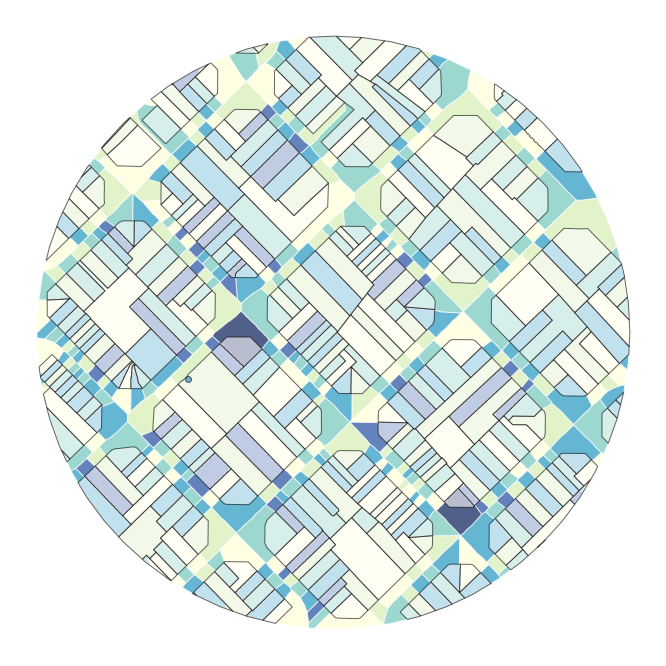

In [77]:
tessellation = voronoi_tessellation.dissolve('unique_id')
ax = barcelona.plot(figsize=(12, 12), facecolor='white', zorder=2, alpha=.6, edgecolor='k')
tessellation.plot(greedy(tessellation, strategy='largest_first'), ax=ax, categorical=True, cmap='YlGnBu', edgecolor='w', alpha=.7)
ax.set_axis_off()

### LA

In [22]:
point = (33.9488360, -118.2372975)
dist = 250
gdf = ox.footprints.footprints_from_point(point, dist)

gdf_projected = ox.projection.project_gdf(gdf)

bounds = gdf_projected.total_bounds
limit = Point(np.mean([bounds[0], bounds[2]]), np.mean([bounds[1], bounds[3]])).buffer(250)
la = gpd.clip(gdf_projected, limit).explode()
la_bounds = la.total_bounds

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


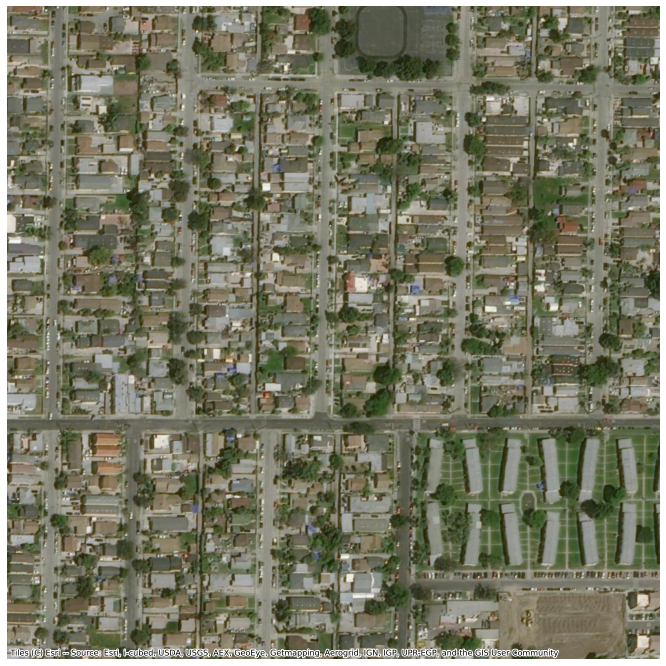

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis([la_bounds[0], la_bounds[2], la_bounds[1], la_bounds[3]])
ctx.add_basemap(ax, crs=gdf_projected.crs, source=ctx.providers.Esri.WorldImagery)
ax.set_axis_off()

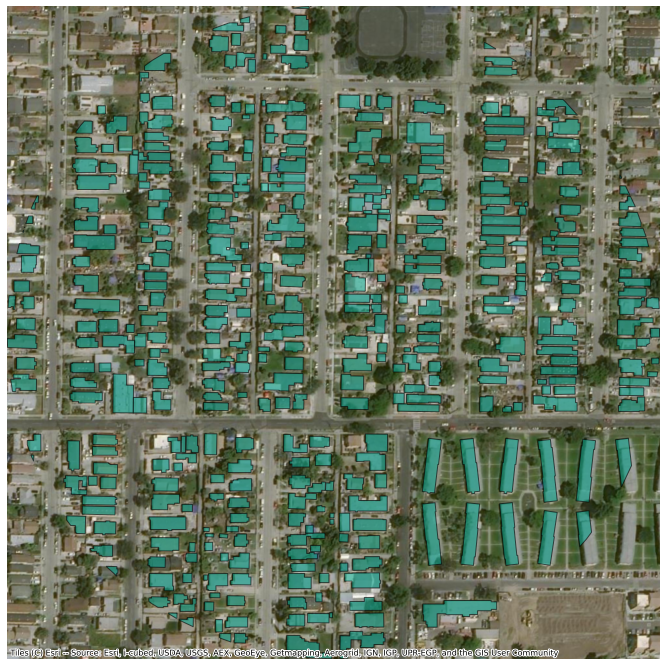

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis([la_bounds[0], la_bounds[2], la_bounds[1], la_bounds[3]])
ctx.add_basemap(ax, crs=la.crs, source=ctx.providers.Esri.WorldImagery)
la.plot(ax=ax, color='#0ea48f', edgecolor='k', alpha=.6)
ax.set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


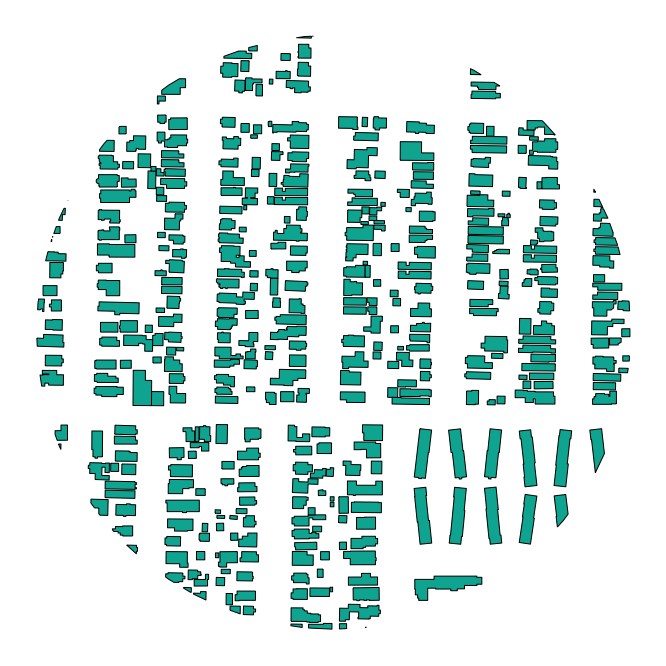

In [24]:
la.plot(figsize=(12, 12), color='#0ea48f', edgecolor='k').set_axis_off()

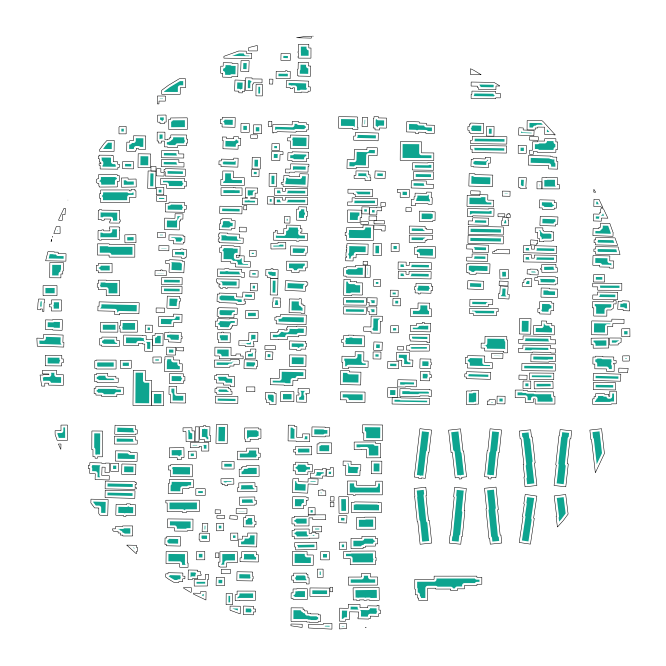

In [37]:
shrinked = la.buffer(-2)
shrinked = shrinked[~shrinked.is_empty]
ax = la.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
shrinked.plot(ax=ax, color='#0ea48f')
ax.set_axis_off()

In [39]:
shrinked = shrinked.reset_index(drop=True).explode()


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


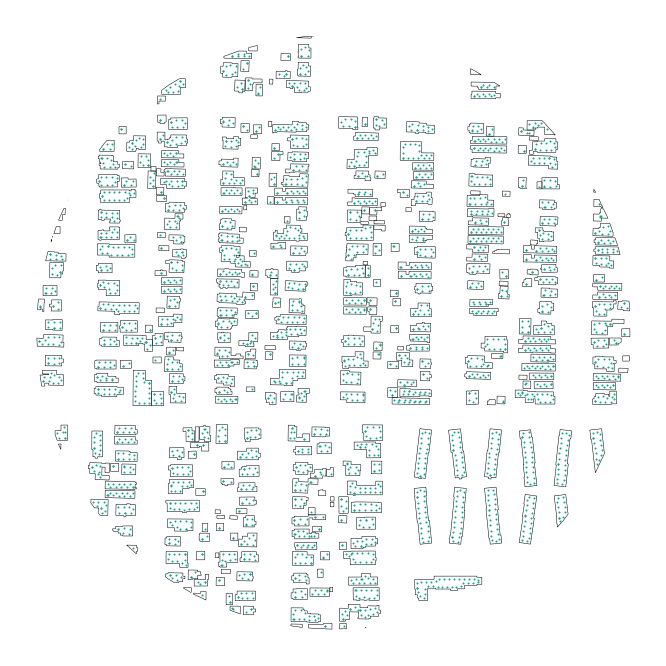

In [42]:
distance = 4

points = np.empty((0, 2))
ids = []
lines = shrinked.exterior.values.data
lengths = shrinked.length
for ix, line, length in zip(shrinked.index, lines, lengths):
    if length > distance:
        pts = pygeos.line_interpolate_point(
            line,
            np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
        )  # .1 offset to keep a gap between two segments
        if len(pts) > 0:
            points = np.append(points, pygeos.get_coordinates(pts), axis=0)
            ids += [ix] * len(pts)

ax = la.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k')
gpd.GeoSeries(pygeos.points(points)).plot(ax=ax, markersize=1, color='#0ea48f')
ax.set_axis_off()

In [43]:
# add hull to resolve issues with infinity
# this is just a correction step ensuring the algorithm will work correctly
print(points.shape)
series = gpd.GeoSeries(limit)
hull = series.geometry[[0]].buffer(500)
line = hull.boundary.values.data[0]
length = hull.length[0]
pts = pygeos.line_interpolate_point(
    line,
    np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance)),
)  # .1 offset to keep a gap between two segments
points = np.append(points, pygeos.get_coordinates(pts), axis=0)
ids += [-1] * len(pts)

(2813, 2)
/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


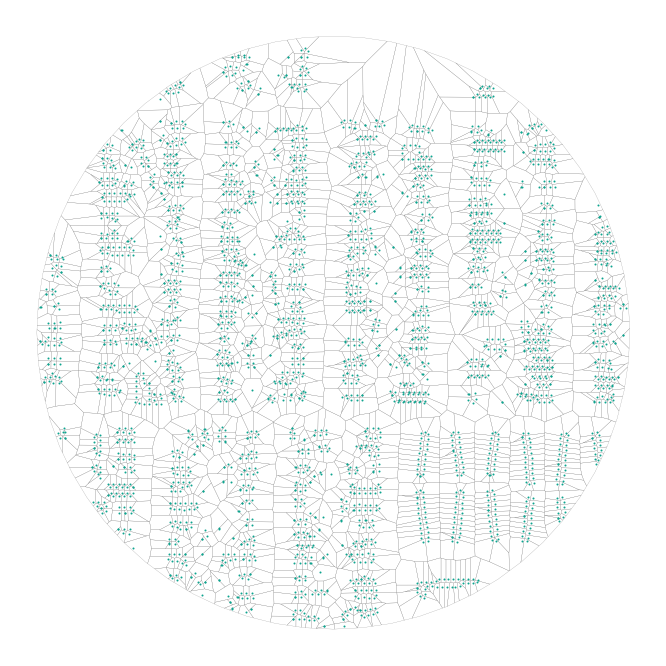

In [44]:
voronoi_diagram = Voronoi(np.array(points))

vertices = pd.Series(voronoi_diagram.regions).take(voronoi_diagram.point_region)
polygons = []
for region in vertices:
    if -1 not in region:
        polygons.append(pygeos.polygons(voronoi_diagram.vertices[region]))
    else:
        polygons.append(None)

regions_gdf = gpd.GeoDataFrame(
    {'unique_id': ids}, geometry=polygons
).dropna()
regions_gdf = regions_gdf.loc[
    regions_gdf['unique_id'] != -1
]  # delete hull-based cells
voronoi_tessellation = gpd.clip(regions_gdf, limit)


# ax = gdf.plot(figsize=(12, 12), facecolor='none', linewidth=.5, edgecolor='k', zorder=2)
ax = gpd.GeoSeries(pygeos.points(points[:2813])).plot(figsize=(12, 12), markersize=1, zorder=3, color='#0ea48f')
voronoi_tessellation.plot(ax=ax, facecolor='none', linewidth=.2, edgecolor='gray')
ax.set_axis_off()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


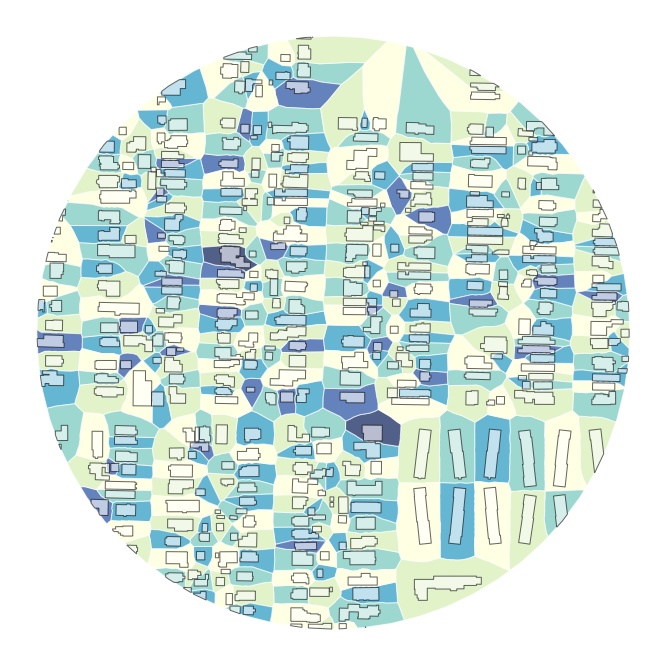

In [54]:
tessellation = voronoi_tessellation.dissolve(voronoi_tessellation.unique_id.apply(lambda x: x[0]))
ax = la.plot(figsize=(12, 12), facecolor='white', zorder=2, alpha=.6, edgecolor='k')
tessellation.plot(greedy(tessellation, strategy='largest_first'), ax=ax, categorical=True, cmap='YlGnBu', edgecolor='w', alpha=.7)
ax.set_axis_off()

## Animation

Sequence:
1. wide sat image
2. zoom to small extent
3. tessellation steps
4. zoom back to large extent